In [4]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:02
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import cv2
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

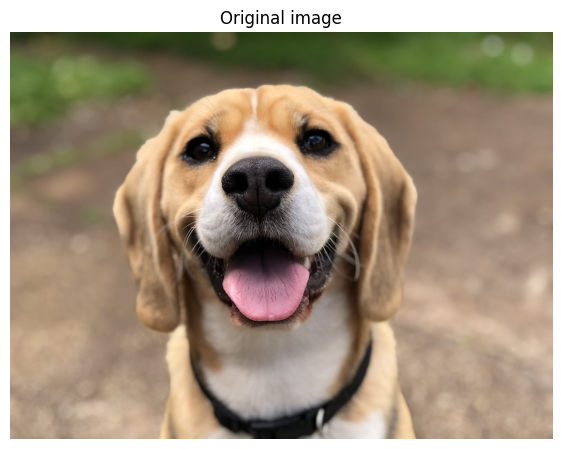

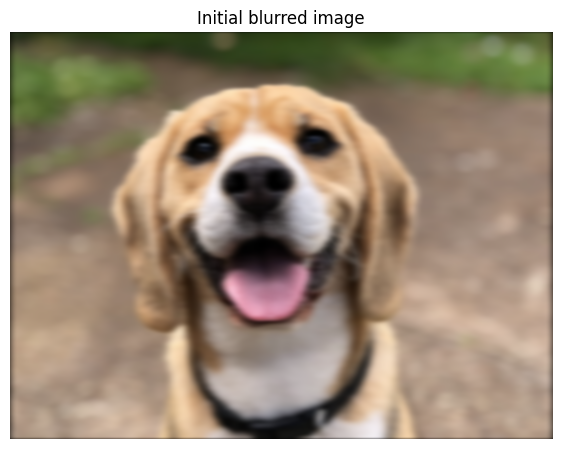

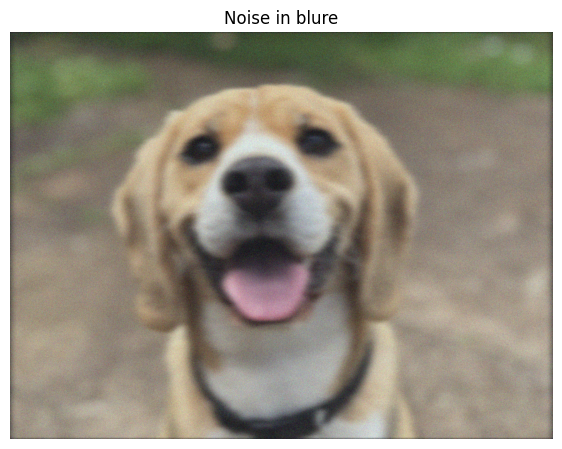

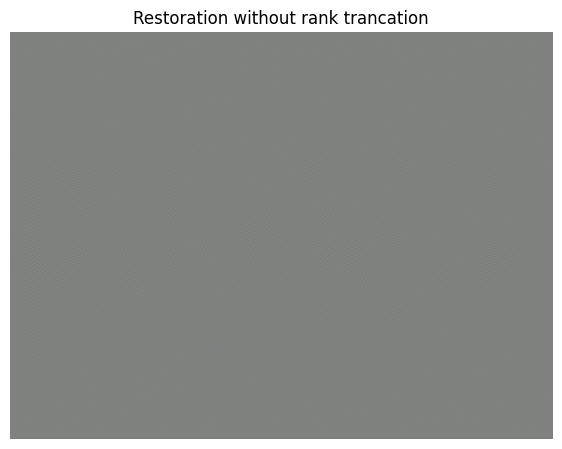

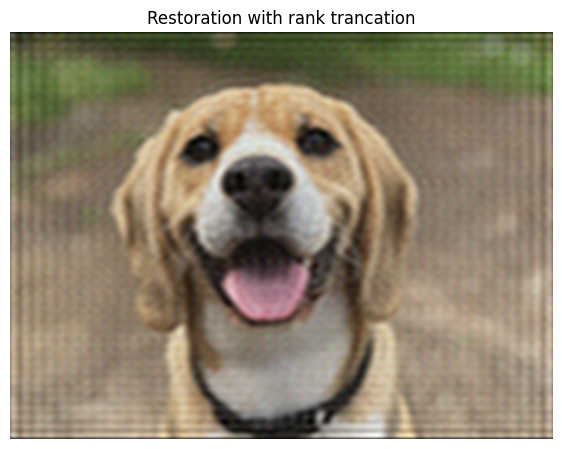

In [144]:
def render_images(images):
    for image_name, image in images:
        plt.figure(figsize=(7,7))
        plt.axis('off')
        plt.imshow(image)
        plt.title(image_name)
        plt.show()
    pass

def create_Toeplitz(size, n_stripes=1, decrease_order=3):
    T = np.zeros(size)
    T[:n_stripes] = (n_stripes - np.arange(0,n_stripes))/(decrease_order*n_stripes)
    T = la.toeplitz(T)
    return T

def deblur(img, ker_h, ker_w, rank=1):
    U_h, S_h, V_h = la.svd(ker_h)
    U_w, S_w, V_w = la.svd(ker_w)
    S_h_invtr = np.hstack([1/S_h[:rank],np.zeros(len(ker_h)-rank)])
    S_w_invtr = np.hstack([1/S_w[:rank],np.zeros(len(ker_w)-rank)])
    ker_h_invtr = V_h.T @ np.diag(S_h_invtr) @ U_h.T
    ker_w_invtr = U_w @ np.diag(S_w_invtr) @ V_w
    return ker_h_invtr @ img @ ker_w_invtr

def scaler(ar1, ar2, ar3):
    ar1 = (254*(ar1 - np.min(ar1))/np.ptp(ar1)).astype(int)
    ar2 = (254*(ar2 - np.min(ar2))/np.ptp(ar2)).astype(int)
    ar3 = (254*(ar3 - np.min(ar3))/np.ptp(ar3)).astype(int)
    return ar1, ar2, ar3
    
# read the image
im = cv2.imread('doggo.jpeg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
h = im.shape[0]
w = im.shape[1]
r, g, b = cv2.split(im)
to_render = []
to_render.append(('Original image', im))

A = create_Toeplitz(size=h, n_stripes=5)
B = create_Toeplitz(size=w, n_stripes=15)
pure_blur_b = A @ b @ B
pure_blur_g = A @ g @ B
pure_blur_r = A @ r @ B
pure_blur_b, pure_blur_g, pure_blur_r = scaler(pure_blur_b, pure_blur_g, pure_blur_r)
pure_blur = np.dstack((pure_blur_r,pure_blur_g,pure_blur_b))
to_render.append(('Initial blurred image', pure_blur))

noisy_blur_b = A @ b @ B + 100*np.random.randn(h,w)
noisy_blur_g = A @ g @ B + 100*np.random.randn(h,w)
noisy_blur_r = A @ r @ B + 100*np.random.randn(h,w)
noisy_blur_b, noisy_blur_g, noisy_blur_r = scaler(noisy_blur_b, noisy_blur_g, noisy_blur_r)
noisy_blur = np.dstack((noisy_blur_r,noisy_blur_g,noisy_blur_b))
to_render.append(('Noise in blure', noisy_blur))

bad_deblur_b = deblur(noisy_blur_b, A, B, rank=min((h,w)))
bad_deblur_g = deblur(noisy_blur_g, A, B, rank=min((h,w)))
bad_deblur_r = deblur(noisy_blur_r, A, B, rank=min((h,w)))
bad_deblur_b, bad_deblur_g, bad_deblur_r = scaler(bad_deblur_b, bad_deblur_g, bad_deblur_r)
bad_deblur = np.dstack((bad_deblur_r,bad_deblur_g,bad_deblur_r))
to_render.append(('Restoration without rank trancation', bad_deblur))

good_deblur_b = deblur(noisy_blur_b, A, B, rank=90)
good_deblur_g = deblur(noisy_blur_g, A, B, rank=90)
good_deblur_r = deblur(noisy_blur_r, A, B, rank=90)
good_deblur_b, good_deblur_g, good_deblur_r = scaler(good_deblur_b, good_deblur_g, good_deblur_r)
good_deblur = np.dstack((good_deblur_r,good_deblur_g,good_deblur_b))
to_render.append(('Restoration with rank trancation', good_deblur))

render_images(to_render)